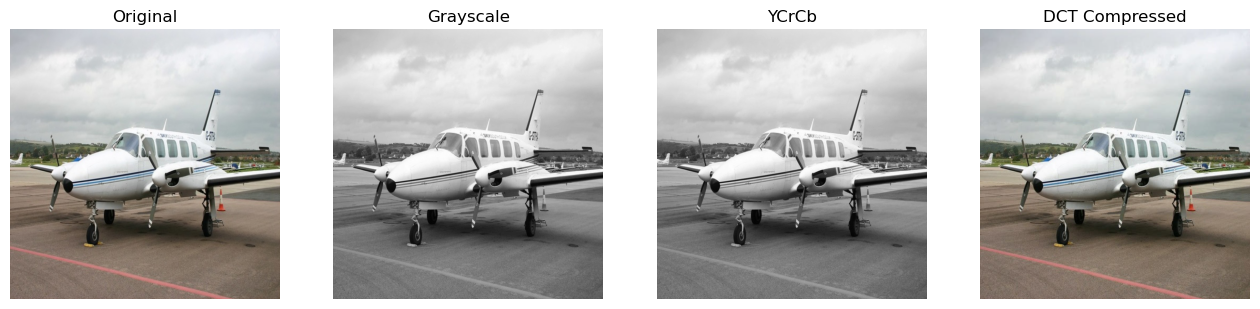

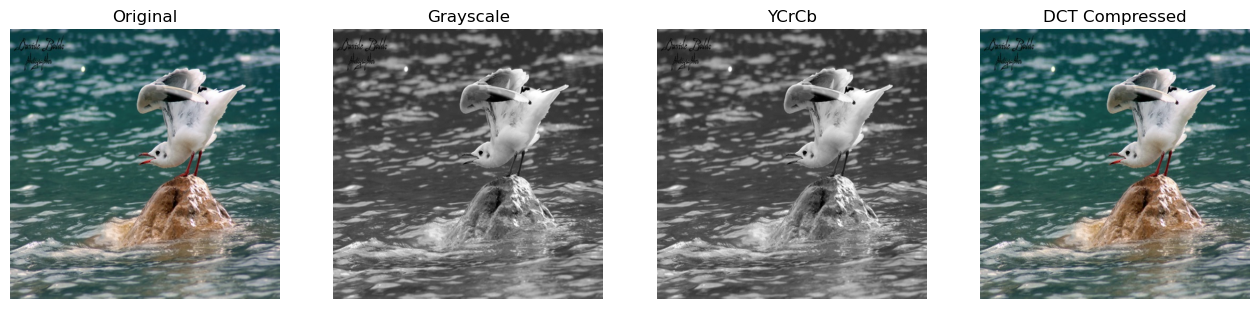

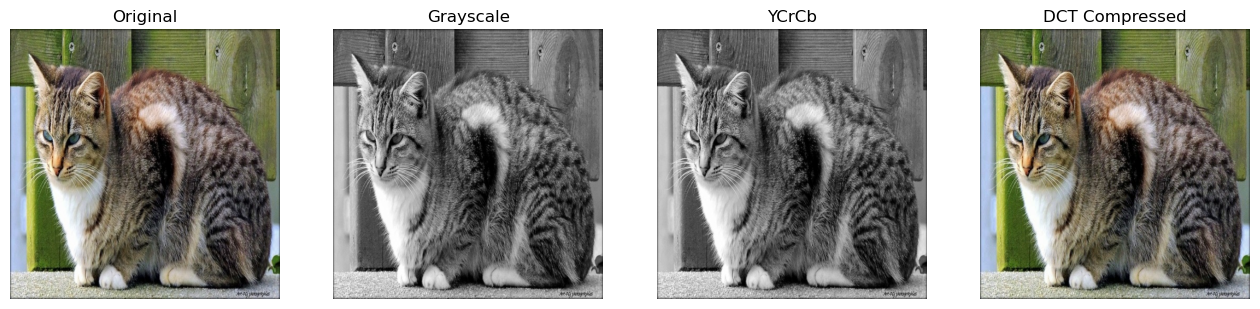

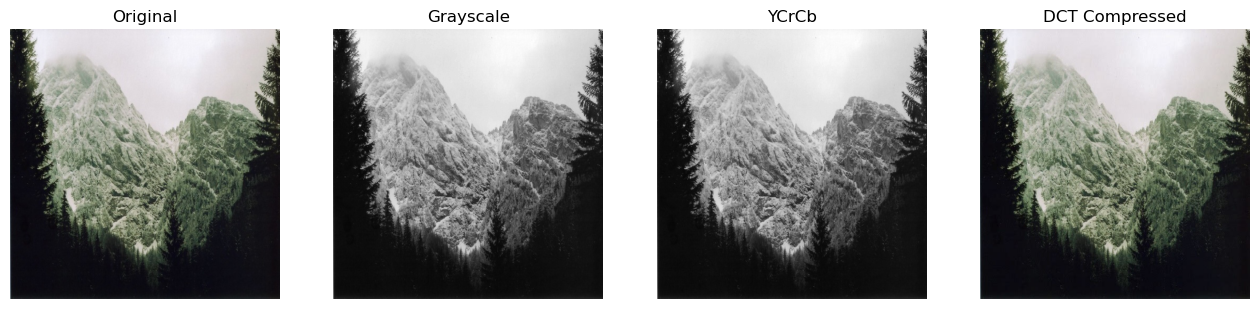

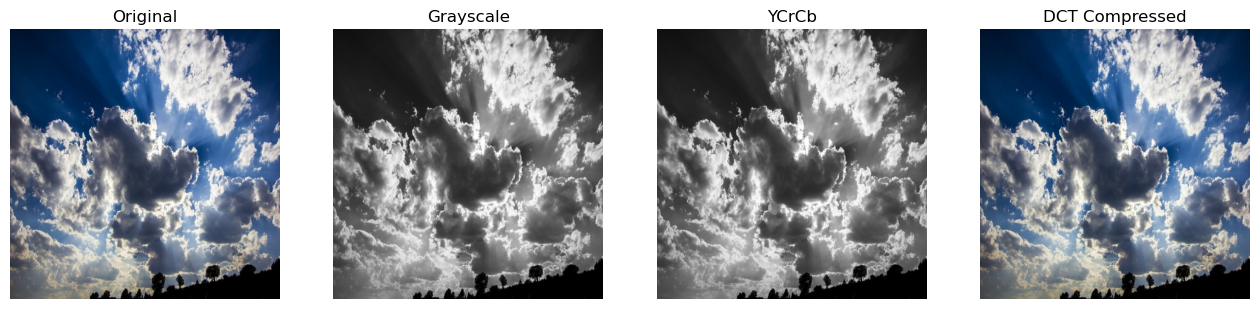

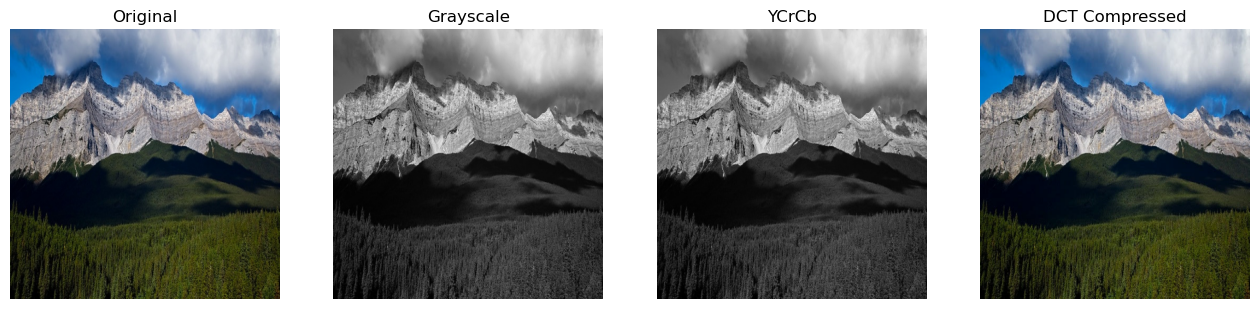

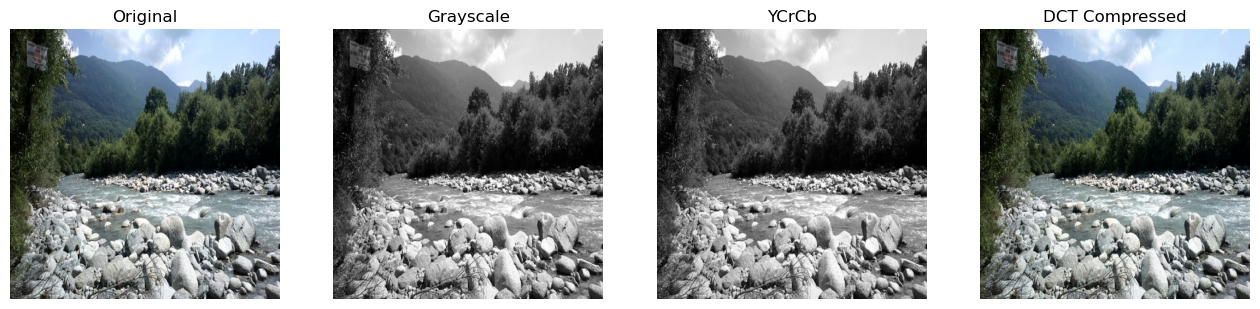

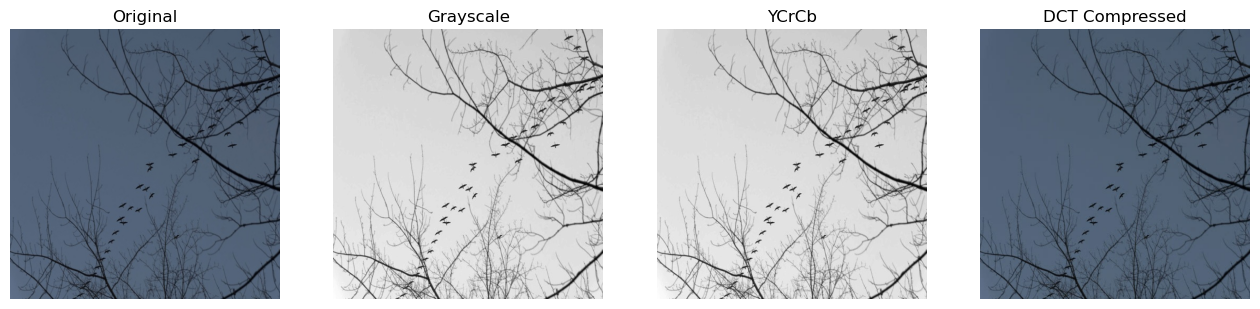

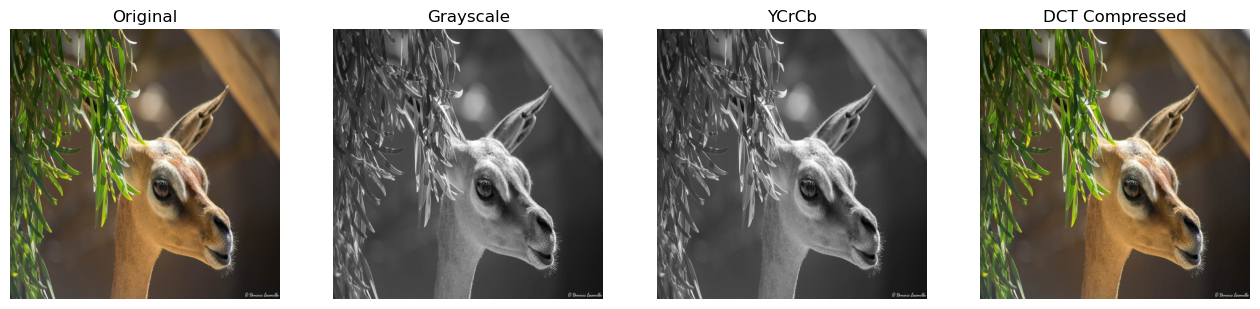

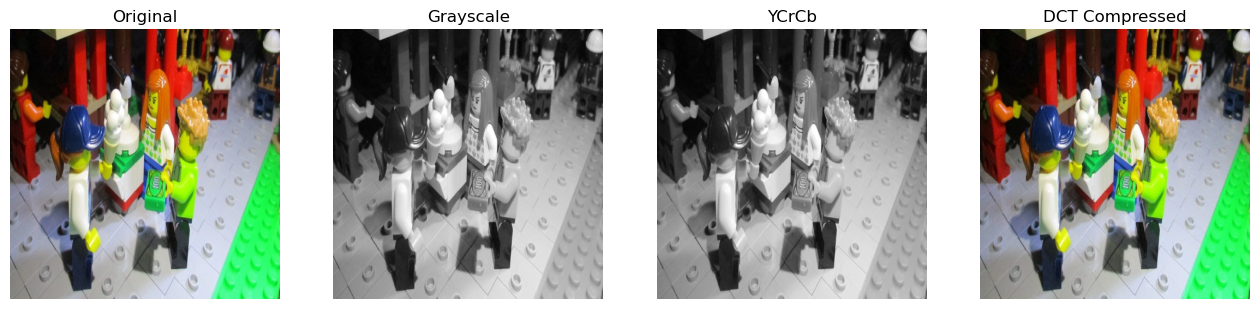

In [2]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import os
import matplotlib.pyplot as plt

INPUT_DIR = r"C:\Users\jayja\Desktop\Images 1"
OUTPUT_DIR = os.path.join(INPUT_DIR, "DCT compressed images")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def dct2(block): return dct(dct(block.T, norm='ortho').T, norm='ortho')
def idct2(block): return idct(idct(block.T, norm='ortho').T, norm='ortho')

def compress_dct(img, quality=30, block_size=8):
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb).astype(np.float32)
    Q = np.ones((block_size, block_size)) * (100-quality)/10 + 1
    Q[0,0] = 1 
    
    h, w, _ = ycbcr.shape
    padded_h, padded_w = int(np.ceil(h/block_size)*block_size), int(np.ceil(w/block_size)*block_size)

    padded = np.zeros((padded_h, padded_w, 3), dtype=np.float32)
    padded[:h,:w,:] = ycbcr
    compressed = np.zeros_like(padded)

    for ch in range(3):
        for i in range(0, padded_h, block_size):
            for j in range(0, padded_w, block_size):
                block = padded[i:i+block_size, j:j+block_size, ch] - 128
                block = np.round(dct2(block)/Q) * Q
                compressed[i:i+block_size, j:j+block_size, ch] = idct2(block)+128

    compressed = np.clip(compressed[:h,:w,:], 0, 255).astype(np.uint8)
    return cv2.cvtColor(compressed, cv2.COLOR_YCrCb2BGR), ycbcr.astype(np.uint8)

shown = 0
for file in os.listdir(INPUT_DIR):
    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path)
    if img is None: continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    compressed_img, ycbcr_img = compress_dct(img, quality=30)

    base, ext = os.path.splitext(file)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base+"_dct.jpg"), compressed_img)

    if shown < 10:
        plt.figure(figsize=(16,4))
        plt.subplot(1,4,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original"); plt.axis('off')

        plt.subplot(1,4,2)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale"); plt.axis('off')

        plt.subplot(1,4,3)
        plt.imshow(ycbcr_img[:,:,0], cmap='gray')
        plt.title("YCrCb"); plt.axis('off')

        plt.subplot(1,4,4)
        plt.imshow(cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB))
        plt.title("DCT Compressed"); plt.axis('off')

        plt.show()
        shown += 1